In [ ]:
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import json

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# **Load & Preprocess Data**

**preprocess the data**

In [ ]:
lines_filepath = os.path.join("/content", "movie_lines.txt")
conv_filepath = os.path.join("/content", "movie_conversations.txt")

In [ ]:
# Visualize some lines
with open(lines_filepath, 'r', encoding='utf-8', errors='ignore') as file:
    lines = file.readlines()
for line in lines[:8]:
    print(line.strip())

L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!
L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!
L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.
L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?
L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.
L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow
L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.
L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No


In [ ]:
# Splits each line of the file into a dictionary of fields (LineID, characterID, movieID, character, text)
line_fields = ["lineID", "characterID", "movieID", "character", "text"]
lines = {}
with open(lines_filepath, 'r', encoding='iso-8859-1') as f:
    for line in f:
        values = line.split(" +++$+++ ")
        # Extract fields
        lineObj = {}
        for i, field in enumerate(line_fields):
            lineObj[field] = values[i]
        lines[lineObj['lineID']] = lineObj

In [ ]:
# Show the first 3 lines
count = 0
for line_id, line_data in lines.items():
    if count < 3:
        print(f"{line_id}: {line_data}")
        count += 1
    else:
        break

L1045: {'lineID': 'L1045', 'characterID': 'u0', 'movieID': 'm0', 'character': 'BIANCA', 'text': 'They do not!\n'}
L1044: {'lineID': 'L1044', 'characterID': 'u2', 'movieID': 'm0', 'character': 'CAMERON', 'text': 'They do to!\n'}
L985: {'lineID': 'L985', 'characterID': 'u0', 'movieID': 'm0', 'character': 'BIANCA', 'text': 'I hope so.\n'}


In [ ]:
# Groups fields of lines from `loadlines` into conversations based on *movie_conversations.txt*
conv_fields = ["character1ID", "character2ID", "movieID", "utteranceIDs"]
conversations = []
with open(conv_filepath, 'r', encoding='iso-8859-1') as f:
    for line in f:
        values = line.split(" +++$+++ ")
        # Extract fields
        convObj = {}
        for i, field in enumerate(conv_fields):
            convObj[field] = values[i]
        # Convert string result from split to list, since convObj["utteranceIDs"] == ['L598485', 'L598486', ...]
        lineIDs = eval(convObj["utteranceIDs"])
        # Reassemble lines
        convObj["lines"] = []
        for lineId in lineIDs:
            convObj["lines"].append(lines[lineId])
        conversations.append(convObj)

In [ ]:
# Show the first 3 conversations
for conv in conversations[:3]:
    print(conv)

{'character1ID': 'u0', 'character2ID': 'u2', 'movieID': 'm0', 'utteranceIDs': "['L194', 'L195', 'L196', 'L197']\n", 'lines': [{'lineID': 'L194', 'characterID': 'u0', 'movieID': 'm0', 'character': 'BIANCA', 'text': 'Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\n'}, {'lineID': 'L195', 'characterID': 'u2', 'movieID': 'm0', 'character': 'CAMERON', 'text': "Well, I thought we'd start with pronunciation, if that's okay with you.\n"}, {'lineID': 'L196', 'characterID': 'u0', 'movieID': 'm0', 'character': 'BIANCA', 'text': 'Not the hacking and gagging and spitting part.  Please.\n'}, {'lineID': 'L197', 'characterID': 'u2', 'movieID': 'm0', 'character': 'CAMERON', 'text': "Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?\n"}]}
{'character1ID': 'u0', 'character2ID': 'u2', 'movieID': 'm0', 'utteranceIDs': "['L198', 'L199']\n", 'lines': [{'lineID': 'L198', 'characterID': 'u0', 'movieID'

In [ ]:
# Extracts pairs of sentences from conversations
qa_pairs = []
for conversation in conversations:
  # Iterate over all the lines of the conversation
  for i in range(len(conversation ["lines"]) - 1):
    inputLine = conversation ["lines"][i]["text"].strip()
    targetLine = conversation["lines"][i+1]["text"].strip()
    # Filter wrong samples (if one of the lists is empty)
    if inputLine and targetLine:
      qa_pairs.append([inputLine, targetLine])

In [ ]:
qa_pairs[0]

['Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.',
 "Well, I thought we'd start with pronunciation, if that's okay with you."]

In [ ]:
# Define path to new file
datafile = os.path.join("/content", "formatted_movie_lines.txt")
delimiter = '\t'
# Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Write new CSV file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter)
    for pair in qa_pairs:
        writer.writerow(pair)
print("Done writing to file")


Writing newly formatted file...
Done writing to file


In [ ]:
# Visualize some lines
datafile = os.path.join("/content", "formatted_movie_lines.txt")
with open(datafile, 'rb') as file:
    lines = file.readlines()
for line in lines[:3]:
    print(line)

b"Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\tWell, I thought we'd start with pronunciation, if that's okay with you.\r\n"
b"Well, I thought we'd start with pronunciation, if that's okay with you.\tNot the hacking and gagging and spitting part.  Please.\r\n"
b"Not the hacking and gagging and spitting part.  Please.\tOkay... then how 'bout we try out some French cuisine.  Saturday?  Night?\r\n"


preprocess the words

In [ ]:
PAD_token = 0   # Used for padding short sentences
SOS_token = 1   # Start-of-sentence token <START>
EOS_token = 2   # End-of-sentence token <END>

class Vocabulary:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        keep_words = []
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {}/{} = {:.4f}'.format(len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)))
        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count default tokens

        for word in keep_words:
            self.addWord(word)

precessing text

In [ ]:
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

# Test the function
unicodeToAscii("Montréal, Française....")

'Montreal, Francaise....'

In [ ]:
# Lowercase, trim white spaces, lines... and remove non-letter characters.
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    # Replace any .!? by a whitespace + the character --> '.!' = ' .!'
    s = re.sub(r"([.!?])", r" \1", s)
    # Remove any character that is not a sequence of lower or upper case letters
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    # Remove a sequence of whitespace characters
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Test the function
normalizeString("aa123aals's   dd?")

'aa aals s dd ?'

In [ ]:
datafile = os.path.join("/content", "formatted_movie_lines.txt")
# Read the file and split into lines
print("Reading and processing file.... Please Wait")
lines = open(datafile, 'r', encoding='utf-8').read().strip().split('\n')
# Split every line into pairs and normalize
pairs = [[normalizeString(s) for s in pair.split('\t')] for pair in lines]
print("Done Reading!")
voc = Vocabulary("/content")

Reading and processing file.... Please Wait
Done Reading!


In [ ]:
len(pairs)

221282

In [ ]:
pairs[0]

['can we make this quick ? roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad . again .',
 'well i thought we d start with pronunciation if that s okay with you .']

filtering the text

In [ ]:
# Returns True if both sentences in a pair 'p' are under the MAX_LENGTH threshold
MAX_LENGTH = 10  # Maximum sentence length to consider (max words)
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split()) < MAX_LENGTH and len(p[1].split()) < MAX_LENGTH

# Filter pairs using filterPair condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
pairs = [pair for pair in pairs if len(pair) > 1]
print("There are {} pairs/conversations in the dataset".format(len(pairs)))
pairs = filterPairs(pairs)
print("After filtering, there are {} pairs/conversations".format(len(pairs)))

There are 221282 pairs/conversations in the dataset
After filtering, there are 64271 pairs/conversations


Getting Rid of Rare Words

In [ ]:
#Loop through each pair of and add the question and reply sentence to the vocabulary
for pair in pairs:
    voc.addSentence (pair[0])
    voc.addSentence (pair[1])
print("Counted words:", voc.num_words)
for pair in pairs[:10]:
    print (pair)

Counted words: 18008
['there .', 'where ?']
['you have my word . as a gentleman', 'you re sweet .']
['hi .', 'looks like things worked out tonight huh ?']
['you know chastity ?', 'i believe we share an art instructor']
['have fun tonight ?', 'tons']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['do you listen to this crap ?', 'what crap ?']
['what good stuff ?', 'the real you .']


In [ ]:
MIN_COUNT = 3  # Minimum word count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)

    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True

        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break

        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs

# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 7823/18005 = 0.4345
Trimmed from 64271 pairs to 53165, 0.8272 of total


# Prepare Data for Models

In [ ]:
def indexesFromSentence (voc, sentence):
  return [voc.word2index [word] for word in sentence.split(' ')] + [EOS_token]



In [ ]:
#Test the function
print(pairs[1][0])
indexesFromSentence (voc, pairs [1][0])

you have my word . as a gentleman


[7, 8, 9, 10, 4, 11, 12, 13, 2]

In [ ]:
# Define some samples for testing
inp = []
out = []
for pair in pairs[:10]:
    inp.append(pair[0])
    out.append(pair[1])
print(inp[3])

indexes = [indexesFromSentence(voc, sentence) for sentence in inp]
indexes[3]

have fun tonight ?


[8, 31, 22, 6, 2]

In [ ]:
def zeroPadding(l, fillvalue=0):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))



leng = [len(ind) for ind in indexes]
print(max(leng))

#Test the function

test_result = zeroPadding (indexes)
print(len(test_result)) #The max length is now the number of rows or the batch size
test_result

10
10


[(3, 7, 16, 8, 33, 35, 42, 47, 50, 58),
 (4, 8, 4, 31, 34, 36, 2, 7, 51, 2),
 (2, 9, 2, 22, 4, 37, 0, 48, 52, 0),
 (0, 10, 0, 6, 4, 38, 0, 40, 6, 0),
 (0, 4, 0, 2, 4, 7, 0, 45, 2, 0),
 (0, 11, 0, 0, 2, 39, 0, 49, 0, 0),
 (0, 12, 0, 0, 0, 40, 0, 6, 0, 0),
 (0, 13, 0, 0, 0, 41, 0, 2, 0, 0),
 (0, 2, 0, 0, 0, 4, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 2, 0, 0, 0, 0)]

In [ ]:
def binaryMatrix(l, value=0):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

binary_result = binaryMatrix(test_result)
binary_result

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
 [0, 1, 0, 1, 1, 1, 0, 1, 1, 0],
 [0, 1, 0, 1, 1, 1, 0, 1, 1, 0],
 [0, 1, 0, 0, 1, 1, 0, 1, 0, 0],
 [0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
 [0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
 [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]

In [ ]:
# Returns padded input sequence tensor and as well as a tensor of lengths for each of the sequences in the batch
#of 1st character
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

In [ ]:
# Returns padded target sequence tensor, padding mask, and max target length
#of 2nd character
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.ByteTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

In [ ]:
# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    # Sort the questions in descending length
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    # assert len(inp) == lengths[0]
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len

In [ ]:
# Example for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:")
print(input_variable)
print("lengths:", lengths)
print("target_variable:")
print(target_variable)
print("mask:")
print(mask)
print("max_target_len:", max_target_len)

input_variable:
tensor([[  50,   25,   94,   50,  787],
        [  92,  200,   25,   75,    6],
        [   7, 2263,  359,    7,    2],
        [ 278,    4,    7, 5936,    0],
        [ 159,   76,  558,    6,    0],
        [   6,   37,    6,    2,    0],
        [ 158,    9,    2,    0,    0],
        [  21,  494,    0,    0,    0],
        [   4,    4,    0,    0,    0],
        [   2,    2,    0,    0,    0]])
lengths: tensor([10, 10,  7,  6,  3])
target_variable:
tensor([[ 213,  124,    7,   25, 5099],
        [ 174,  115,   94,  387,    6],
        [ 214,   36,  359,  349,    2],
        [   4,  147,   83,    4,    0],
        [   2,   76,   95,    2,    0],
        [   0,  115,    4,    0,    0],
        [   0,    6,    2,    0,    0],
        [   0,    2,    0,    0,    0]])
mask:
tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0],
        [0, 1, 1, 0, 0],
        [0, 1, 1, 0, 0],
        [0, 1, 0, 0, 0]], 

# Define Models

Encoder

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        # because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # input_seq: batch of input sentences; shape=(max_length, batch_size)
        # input_lengths: list of sentence lengths corresponding to each sentence in the batch
        # hidden state, of shape: (n_layers x num_directions, batch_size, hidden_size)

        # Convert word indices to embeddings
        embedded = self.embedding(input_seq)

        # Pack padded batch of sequences for RNN module
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)

        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)

        # Unpack padding
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)

        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, :, self.hidden_size:]

        # Return output and final hidden state
        return outputs, hidden

Attention

In [ ]:
# Luong attention layer
class Attn(torch.nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        self.hidden_size = hidden_size

    def dot_score(self, hidden, encoder_output):
        # Element-Wise Multiply the current target decoder state with the encoder output and sum them
        return torch.sum(hidden * encoder_output, dim=2)

    def forward(self, hidden, encoder_outputs):
        # hidden of shape: (1, batch_size, hidden_size)
        # encoder_outputs of shape: (max_length, batch_size, hidden_size)
        # (1, batch_size, hidden_size) * (max_length, batch_size, hidden_size) = (max_length, batch_size, hidden_size)

        # Calculate the attention weights (energies)
        attn_energies = self.dot_score(hidden, encoder_outputs)  # (max_length, batch_size)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()  # (batch_size, max_length)

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)  # (batch_size, 1, max_length)

Decoder witn Attention

In [ ]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # input_step: one time step (one word) of input sequence batch; shape=(1, batch_size)
        # last_hidden: final hidden layer of GRU; shape=(n_Layers x num_directions, batch_size, hidden_size)
        # encoder_outputs: encoder model's output; shape=(max_length, batch_size, hidden_size)
        # Note: we run this one step (word) at a time

        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)

        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)

        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)

        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        # (batch_size,1, max_length) bmm with (batch_size, max_length, hidden) = (batch_size,1, hidden)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))

        # Concatenate weighted context vector and GRU output
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))

        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)

        # Return output and final hidden state
        return output, hidden


        #output: softmax normalized tensor giving probabilities of each word being the correct next word in the decoded sequence
        #shape=(batch_size, voc.num_words)
        # hidden: final hidden state of GRU; shape=(n_layers x num_directions, batch_size, hidden_size)

# Loss fct & single training iteration

Masked loss

In [ ]:
def maskNLLLoss(decoder_out, target, mask):
    # Convert mask to boolean tensor (CRITICAL)
    bool_mask = mask.bool()
    nTotal = bool_mask.sum().item()  # Number of non-padded tokens

    # Handle empty mask case (no valid tokens)
    if nTotal == 0:
        return torch.tensor(0.0, device=decoder_out.device), 0

    # Reshape target for gathering
    target = target.view(-1, 1)
    gathered_tensor = torch.gather(decoder_out, 1, target)

    # Calculate loss per token
    crossEntropy = -torch.log(gathered_tensor.squeeze(1))

    # Apply boolean mask and calculate mean loss
    loss = crossEntropy.masked_select(bool_mask).mean()

    return loss, nTotal

Single training iteration

In [ ]:
# Visualizing what's happening in one iteration. Only run this for visualization.
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable shape:", input_variable.shape)
print("lengths shape:", lengths.shape)
print("target_variable shape:", target_variable.shape)
print("mask shape:", mask.shape)
print("max_target_len:", max_target_len)

# Define the parameters
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
attn_model = 'dot'
embedding = nn.Embedding(voc.num_words, hidden_size)

# Define the encoder and Decoder
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
encoder = encoder.to(device)
decoder = decoder.to(device)
# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.0001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.0001)
encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()

input_variable = input_variable.to(device)
lengths = lengths.to(device)
target_variable = target_variable.to(device)
mask = mask.to(device)

loss = 0
print_losses = []
n_totals = 0

encoder_outputs, encoder_hidden = encoder(input_variable, lengths.cpu())
print("Encoder Outputs Shape:", encoder_outputs.shape)
print("Last Encoder Hidden Shape", encoder_hidden.shape)

decoder_input = torch.LongTensor([[SOS_token for _ in range(small_batch_size)]])
decoder_input = decoder_input.to(device)
print("Initial Decoder Input Shape:", decoder_input.shape)
print(decoder_input)

# Set initial decoder hidden state to the encoder's final hidden state
decoder_hidden = encoder_hidden[:decoder.n_layers]
print("Initial Decoder hidden state shape:", decoder_hidden.shape)
print("\n")
print("---------------------------------------------")
print("Now Let's look what's happening in every timestep of the GRU!")
print("---------------------------------------------")
print("\n")


# Assume we are using Teacher Forcing
for t in range(max_target_len):
    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
    print("Decoder Output Shape:", decoder_output.shape)
    print("Decoder Hidden Shape:", decoder_hidden.shape)

    # Teacher forcing: next input is current target
    decoder_input = target_variable[t].view(1, -1)
    print("The target variable at the current timestep before reshaping:", target_variable[t])
    print("The target variable at the current timestep shape before reshaping:", target_variable[t].shape)
    print("The Decoder input shape (reshape the target variable):", decoder_input.shape)

    # Calculate and accumulate loss
    print("The mask at the current timestep:", mask[t])
    print("The mask at the current timestep shape:", mask[t].shape)
    mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
    print("Mask Loss:", mask_loss)
    print("Total:", nTotal)
    loss += mask_loss
    print_losses.append(mask_loss.item() * nTotal)
    n_totals += nTotal

    print(n_totals)
    encoder_optimizer.step()
    decoder_optimizer.step()
    returned_loss = sum(print_losses) / n_totals
    print("Returned Loss: ", returned_loss)
    print("\n")
    print("----------------ONE TIMESTEP----------------")
    print("\n")

input_variable shape: torch.Size([8, 5])
lengths shape: torch.Size([5])
target_variable shape: torch.Size([10, 5])
mask shape: torch.Size([10, 5])
max_target_len: 10
Encoder Outputs Shape: torch.Size([8, 5, 500])
Last Encoder Hidden Shape torch.Size([4, 5, 500])
Initial Decoder Input Shape: torch.Size([1, 5])
tensor([[1, 1, 1, 1, 1]], device='cuda:0')
Initial Decoder hidden state shape: torch.Size([2, 5, 500])


---------------------------------------------
Now Let's look what's happening in every timestep of the GRU!
---------------------------------------------


Decoder Output Shape: torch.Size([5, 7826])
Decoder Hidden Shape: torch.Size([2, 5, 500])
The target variable at the current timestep before reshaping: tensor([ 25,  94, 318, 100, 124], device='cuda:0')
The target variable at the current timestep shape before reshaping: torch.Size([5])
The Decoder input shape (reshape the target variable): torch.Size([1, 5])
The mask at the current timestep: tensor([1, 1, 1, 1, 1], device='c

# Training function

In [ ]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)

    target_variable = target_variable.to(device)
    mask = mask.to(device)

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropagation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    # With this safe division:
    if n_totals == 0:
        return 0.0  # Avoid division by zero
    else:
        return sum(print_losses) / n_totals

# training iterations

In [ ]:
# Define training parameters
model_name = 'chatbot_model'
n_iteration = 5000  # Number of training steps
batch_size = 64
clip = 50.0  # Gradient clipping threshold
teacher_forcing_ratio = 1.0  # Start with full teacher forcing
learning_rate = 0.0001
print_every = 100  # Print loss every N batches

# Initialize models and optimizers
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
attn_model = 'dot'

embedding = nn.Embedding(voc.num_words, hidden_size)
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
encoder = encoder.to(device)
decoder = decoder.to(device)

encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * 5.0)



In [ ]:
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer,
               decoder_optimizer, embedding, n_iteration, batch_size, clip,
               print_every=100, plot_every=100, save_every=500):
    # Initialize metrics tracking
    start_iteration = 1
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0   # Reset every plot_every
    all_losses = []
    start_time = time.time()

    print(f"Starting training for {n_iteration} iterations...")
    print(f"Batch size: {batch_size}, Print every: {print_every}, Save every: {save_every}")

    for iteration in range(start_iteration, n_iteration + 1):
        # Get training batch
        training_batch = batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        lengths = lengths.cpu()

        # Run training iteration
        loss = train(input_variable, lengths, target_variable, mask, max_target_len,
                     encoder, decoder, embedding, encoder_optimizer, decoder_optimizer,
                     batch_size, clip)

        # Update tracking metrics
        print_loss_total += loss
        plot_loss_total += loss
        all_losses.append(loss)

        # Calculate progress metrics
        time_elapsed = time.time() - start_time
        iterations_done = iteration - start_iteration + 1
        time_per_iter = time_elapsed / iterations_done
        remaining_iters = n_iteration - iteration
        eta_seconds = remaining_iters * time_per_iter
        eta_str = time.strftime("%H:%M:%S", time.gmtime(eta_seconds))

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0

            progress_percent = iteration / n_iteration * 100
            print(f"[{time.strftime('%H:%M:%S')}] Iteration: {iteration}/{n_iteration} ({progress_percent:.1f}%)")
            print(f"  Loss: {print_loss_avg:.4f} | ETA: {eta_str}")
            print(f"  Avg time per iter: {time_per_iter:.2f}s | Elapsed: {time_elapsed/60:.1f}min")

            # Optional: Print sample prediction
            if iteration % (print_every * 5) == 0:
                sample_prediction(encoder, decoder, voc, pairs)

        # Update plot
        if iteration % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_loss_total = 0
            clear_output(wait=True)
            plt.figure(figsize=(10, 5))
            plt.plot(all_losses, label='Training Loss')
            plt.xlabel('Iterations')
            plt.ylabel('Loss')
            plt.title(f'Training Progress (Current Loss: {plot_loss_avg:.4f})')
            plt.grid(True)
            plt.legend()
            plt.show()

        # Save checkpoint
        if iteration % save_every == 0:
            save_path = f"{model_name}_{iteration}.pth"
            torch.save({
                'iteration': iteration,
                'encoder': encoder.state_dict(),
                'decoder': decoder.state_dict(),
                'encoder_optimizer': encoder_optimizer.state_dict(),
                'decoder_optimizer': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc': voc
            }, save_path)
            print(f"Saved checkpoint to {save_path}")

    # Save final model
    final_save_path = f"{model_name}_final.pth"
    torch.save({
        'encoder': encoder.state_dict(),
        'decoder': decoder.state_dict(),
        'voc': voc
    }, final_save_path)
    print(f"Training complete! Final model saved to {final_save_path}")

    return all_losses

for the metrics

In [ ]:
def sample_prediction(encoder, decoder, voc, pairs, n=3):
    """Generate sample predictions during training"""
    encoder.eval()
    decoder.eval()

    print("\nSample Predictions:")
    for _ in range(n):
        pair = random.choice(pairs)
        input_sentence = pair[0]
        target_sentence = pair[1]

        # Format input sentence
        input_tokens = [word for word in input_sentence.split(' ') if word]
        input_indexes = [voc.word2index[word] for word in input_tokens]
        input_batch = torch.LongTensor([input_indexes]).transpose(0, 1).to(device)
        lengths = torch.tensor([len(input_indexes)]).cpu()

        # Generate response
        response = generate_response(encoder, decoder, voc, input_batch, lengths)

        print(f"Input: {input_sentence}")
        print(f"Target: {target_sentence}")
        print(f"Model: {response}\n")

    encoder.train()
    decoder.train()


def generate_response(encoder, decoder, voc, input_batch, input_length, max_length=MAX_LENGTH):
    """Generate response from input sequence"""
    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_batch, input_length)

    # Create decoder input
    decoder_input = torch.LongTensor([[SOS_token]]).to(device)
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    decoded_words = []
    for _ in range(max_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)

        # Choose top word
        _, topi = decoder_output.topk(1)
        ni = topi.squeeze().item()

        if ni == EOS_token:
            break
        else:
            decoded_words.append(voc.index2word[ni])

        # Next input is current output
        decoder_input = torch.LongTensor([[ni]]).to(device)

    return ' '.join(decoded_words)

start training

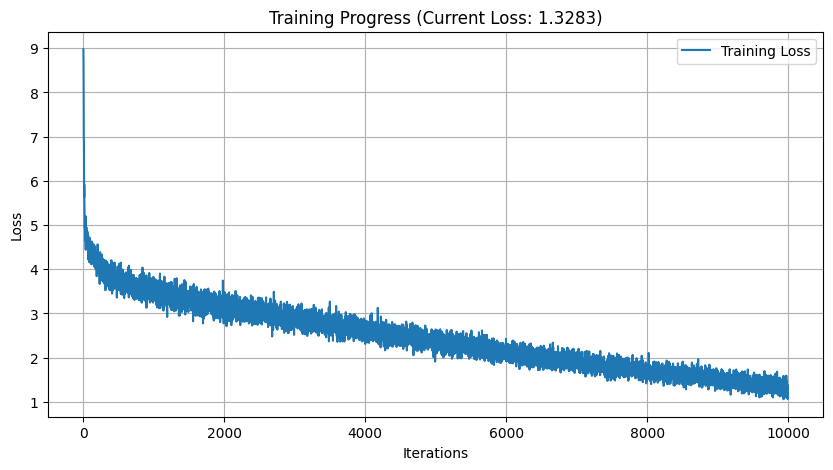

Saved checkpoint to chatbot_10000.pth
Training complete! Final model saved to chatbot_final.pth


In [ ]:
# Training parameters
model_name = 'chatbot'
n_iteration = 10000 #save model each 1000 iterations
batch_size = 64
clip = 50.0


# Start training
loss_history = trainIters(
    model_name=model_name,
    voc=voc,
    pairs=pairs,
    encoder=encoder,
    decoder=decoder,
    encoder_optimizer=encoder_optimizer,
    decoder_optimizer=decoder_optimizer,
    embedding=embedding,
    n_iteration=n_iteration,
    batch_size=batch_size,
    clip=clip,
    print_every=100,    # Print metrics every 100 iterations
    plot_every=200,     # Update plot every 200 iterations
    save_every=1000     # Save checkpoint every 1000 iterations
)

# ETA 8min

# chatting functions

In [ ]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Ensure lengths stay on CPU
        if input_length.is_cuda:
            input_length = input_length.cpu()

        # Forward pass through encoder
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)

        # Prepare decoder initial state
        decoder_hidden = encoder_hidden[:self.decoder.n_layers]

        # Initialize decoder input with SOS token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token

        # Track decoded tokens
        decoded_tokens = []

        for _ in range(max_length):
            decoder_output, decoder_hidden = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )

            # Get most likely token
            _, topi = decoder_output.topk(1)
            ni = topi.squeeze().item()

            # Stop at EOS token
            if ni == EOS_token:
                break

            decoded_tokens.append(ni)
            decoder_input = torch.LongTensor([[ni]]).to(device)

        return decoded_tokens

In [ ]:
def chat(encoder, decoder, voc):
    encoder.eval()
    decoder.eval()
    searcher = GreedySearchDecoder(encoder, decoder)

    print("Chat with the bot (type 'quit' or 'exit' or 'q' to exit)")
    while True:
        try:
            input_sentence = input("You: ")
            if input_sentence.lower() in ['quit', 'exit', 'q']:
                break

            # Normalize and tokenize
            input_sentence = normalizeString(input_sentence)
            tokens = [word for word in input_sentence.split(' ') if word]

            # Convert to indexes with UNK handling
            indexes = []
            for word in tokens:
                if word in voc.word2index:
                    indexes.append(voc.word2index[word])
                else:
                    indexes.append(UNK_token)  # Use unknown token
            indexes.append(EOS_token)

            # Create tensors - LENGTHS MUST STAY ON CPU
            lengths = torch.tensor([len(indexes)])
            input_batch = torch.LongTensor([indexes]).transpose(0, 1).to(device)

            # Decode response
            tokens = searcher(input_batch, lengths, MAX_LENGTH)
            decoded_words = [voc.index2word[token] for token in tokens]

            # Format response (remove special tokens)
            response = ' '.join([word for word in decoded_words
                                if word not in ['EOS', 'PAD', 'SOS', '<eos>', '<pad>', '<sos>']])
            print(f"Bot: {response}")

        except Exception as e:
            print(f"Error: {str(e)}")

# start chatting

In [ ]:
# Run all Define Models cells
# Run maskNLLLoss function

In [ ]:
#load checkpoint of final model
checkpoint = torch.load('/content/chatbot_final.pth', map_location=device, weights_only=False)

# Extract components
voc = checkpoint['voc']
encoder_weights = checkpoint['encoder']
decoder_weights = checkpoint['decoder']

# Recreate models
embedding = nn.Embedding(voc.num_words, hidden_size)
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)

# Load weights
encoder.load_state_dict(encoder_weights)
decoder.load_state_dict(decoder_weights)

# Move to device and set eval mode
encoder = encoder.to(device).eval()
decoder = decoder.to(device).eval()

In [ ]:
# start chatting 🎉
chat(encoder, decoder, voc)

Chat with the bot (type 'quit' or 'exit' or 'q' to exit)
You: hello
Bot: hello .
You: how are you ?
Bot: okay .
You: where am i ?
Bot: you re in a hospital in london .
You: do you drink water ?
Bot: no .


KeyboardInterrupt: Interrupted by user